# Ejercicio 1

En este notebook se pretende crear un sistema estocástico básico para simulaciones. La idea es encontrar el FPT de este proceso y crear un método discreto que sirva para encontrar la probabilidad de pasar el umbral establecido.

Se partirá con la creación de una clase que sea el proceso, el cual es capaz de generar números aleatorios a partir de un sistema básico determinado por una ecuación de evolución (dinámica del sistema).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
from scipy.stats import norm
import scipy.integrate as integrate
import math

Primero, hay que calcular la distribución de probabilidad del tiempo de falla de un proceso simple:

$$ x_{t+1} = a_1 x_t + \mu_{t+1} $$

Donde $\mu \sim N(0,\sigma)$ y $a_1$ es una constante del proceso.

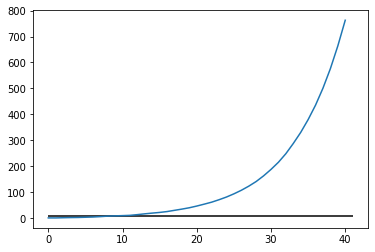

In [221]:
x_0 = 1
N = 41

proceso = np.zeros((N,))
proceso[0] = x_0
a1 = 1.15
sigma = 0.6
np.random.seed(32)
u = 7
K = 0

for i in range(N-1):
    
    proceso[i + 1] = K + a1 * proceso[i] + np.random.normal(0, sigma)

plt.plot(proceso)
plt.hlines(u,0,N)

A continuación se definen funciones auxiliares para calcular la media y la varianza de forma teóricas

In [222]:
def E(t, dt, x_=None):
    x = 0

    for i in range(dt): x += a1**i
    x *= K
    
    if x_ is not None: x += (a1**dt) * x_
    else: x += (a1**dt) * proceso[t]
    
    return x

def Var(t, dt, x_=None):
    x = 0
    
    for i in range(dt): x += a1**(2*i)
    
    x *= sigma**2
    
    return x

def integrand(x, n, i, j):

#     print(n,i,j)
#     print(x)
#     aux = norm.pdf( (x - E(n, j)) / Var(n, j) ) # bien
    aux = norm.pdf( x , loc=E(n, j), scale=Var(n, j) ) # bien
    aux *= 1 - norm.cdf(u, loc=E(n + i, i - j, x), scale=Var(n + i, i - j, x) )
    return aux

Ahora hay que correr un montecarlo para capturar la primera pasada por un umbral

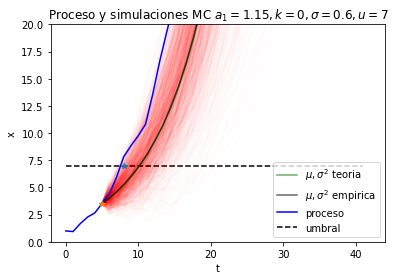

5
8


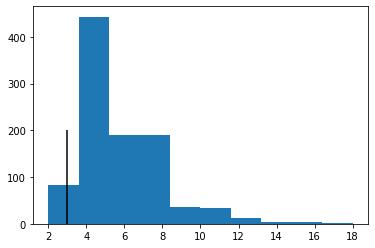

In [223]:
M = 1000 # cantidad de simulaciones
n = 5 # punto inicial donde se comienza a predecir
PROCESOS = np.zeros((M, N - n)) # simulaciones
FPT = [] # tiempos de primera pasada

for i in range(M):
    
    s = 0
    x = np.zeros((N - n,))
    t = np.linspace(n, N, num=N-n)
    x[0] = proceso[n]
    first_time = True
    
    for j in range(len(x) - 1):
    
        x[j + 1] = K + a1 * x[j] + np.random.normal(0, sigma)
    
        if x[j] >= u and first_time:
            FPT.append(j)
            first_time = False
#             break

    PROCESOS[i, :] = x
    plt.plot(t, x, color='r', alpha=0.01)

t = np.linspace(n, N + 1, num=N-n)
media = np.zeros((N - n,))
varianza = np.zeros((N - n,))

media_e = np.zeros((N - n,))
varianza_e = np.zeros((N - n,))

for i in range(len(x)):
    
    # media y varianzas teoricas
    media[i] = E(n, i)
    varianza[i] = Var(n, i)
    
    # media y varianzas empiricas
    media_e[i] = np.mean(PROCESOS[:,i])
    varianza_e[i] = np.var(PROCESOS[:,i])

plt.plot(t, media, color='g', alpha=0.6, label='$\mu, \sigma^2$ teoria')
# plt.plot(t, media + varianza, t, media - varianza, color='g', alpha=0.3)

plt.plot(t, media_e, color='k', alpha=0.6, label='$\mu, \sigma^2$ empirica')
# plt.plot(t, media_e + varianza_e, t, media_e - varianza_e, color='k', alpha=0.3)

plt.plot(proceso, color='b', label='proceso')
plt.hlines(u,0,N, color='k', linestyles='dashed', label='umbral')
plt.plot(np.where(proceso >= u)[0][0], u, '*')
plt.plot(n, proceso[n], '*')
# plt.ylim(bottom=0)
plt.ylim(top=20, bottom=0)
plt.legend(), plt.ylabel('x'), plt.xlabel('t')
plt.title('Proceso y simulaciones MC $a_1={}, k={}, \sigma={}, u={}$'.format(a1, K, sigma, u))
plt.show()

plt.hist(FPT)
print(n)
print(np.where(proceso >= u)[0][0])
plt.vlines(np.where(proceso >= u)[0][0] - n, 0, 200)
plt.show()

Ahora se debe calcular la distribución de probabilidad según el paper de referencia

Para ello se utiliza el sistema de ecuaciones expresado en el paper:

$
\left[{\begin{array}[c]\\
        Pr(a_1) \\ Pr(a_2) \\ ... \\ Pr(a_k) 
\end{array} }\right] = \Theta \times \left[{\begin{array}[c] 
    q_1 \\ q_2 \\ ... \\ q_k
\end{array}}\right]
$


Comprobar que la distribución de probabilidad de la variable dada sea la misma que la pronosticada por monte carlo. Para ello se tomará un instante arbitrario y se graficará el histograma de la variable. Además de calcular la media y la varianza de la distribución que debería resultar en aquel momento.

In [224]:
print(proceso[20])
print(proceso[21])
print(E(20,2))
print(Var(20,2))

print(integrand(proceso[ n + 6 ], n, 3, 2))

46.65973096600493
53.96207768620205
61.70749420254151
0.8360999999999998
8.453827037864743e-13


36

<ipython-input-225-063438a2ca8a>:20: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  integral = integrate.quad(integrand, u, np.inf, args=(n, i + 1, j + 1)) # bien


40

<ipython-input-225-063438a2ca8a>:20: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = integrate.quad(integrand, u, np.inf, args=(n, i + 1, j + 1)) # bien



 -8.645000257358543e-06

 1.0


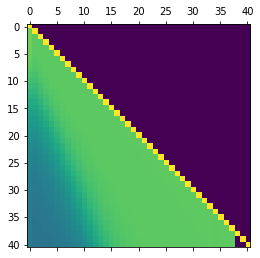

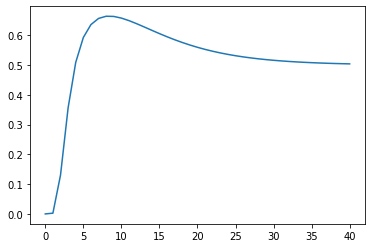

In [225]:
k = N
A = np.zeros((k,))
theta = np.zeros((k,k))

for i in range(k):
    
    A[i] = 1 - norm.cdf(u, loc=E(n,i + 1), scale=Var(n,i + 1)) # bien
    
    theta[i, i] = 1
    print('\r{}'.format(i), end='', flush=True)
    
    for j in range(i): # i,j
        
        aux = 1 - norm.cdf(u, loc=E(n, j + 1), scale=Var(n, j + 1))
        
        if aux == 0:
            theta[i, j] = 0
        else:
            theta[i, j] = 1 / aux # bien
            integral = integrate.quad(integrand, u, np.inf, args=(n, i + 1, j + 1)) # bien
            
            theta[i, j] *= integral[0] * 0.75
#             theta[i, j] = 1
            
print('\n',np.min(theta))
print('\n',np.max(theta))
plt.matshow(theta)
plt.show()
# print(theta)
plt.plot(A)
plt.show()

Ahora viene el álgebra para calcular la distribución de probabilidades

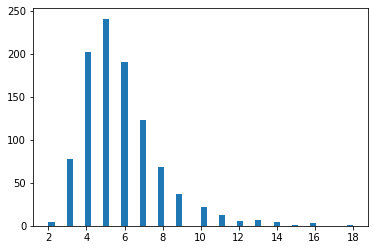

36
41


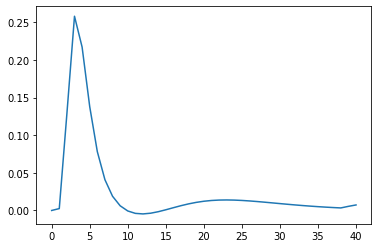

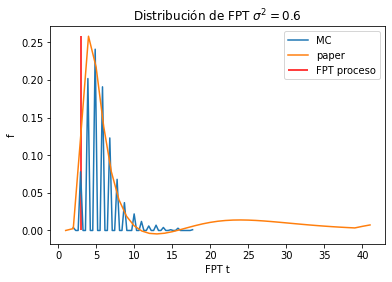

In [226]:
q = np.matmul(np.linalg.inv(theta), A)
# print(np.multiply(q >= 0, q < 1))
# aux = np.multiply(q >= 0, q < 1)
# print(aux)
a = plt.hist(FPT, bins=50)
plt.show()

print(np.sum(np.multiply(q >= 0, q < 10)))
print(len(np.multiply(q >= 0, q < 10)))
# plt.plot(q[np.multiply(q >= 0, q < 10)]), plt.show()
plt.plot(q), plt.show()


b = a[0] / np.max(a[0])
plt.plot(a[1][:-1], b / np.sum(b), label='MC')
plt.plot(np.array(range(len(q))) + 1, q, label='paper')
plt.xlabel('FPT t')
plt.vlines(np.where(proceso >= u)[0][0] - n, 0, np.max(q), color='r', label='FPT proceso')
plt.ylabel('f')
plt.title('Distribución de FPT $\sigma^2 =${}'.format(sigma))
plt.legend(loc='best')
plt.show()

Como lo anterior puede dar resultados no óptimos y con problemas de matrices singulares, se tratará de calcular la probabilidad con un método iterativo que calcule línea a línea con recursividad la probabilidad que buscamos

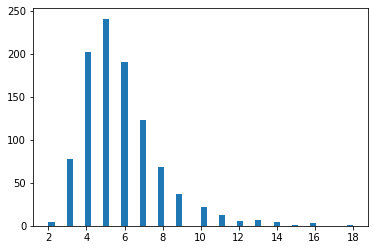

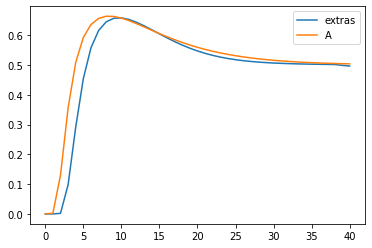

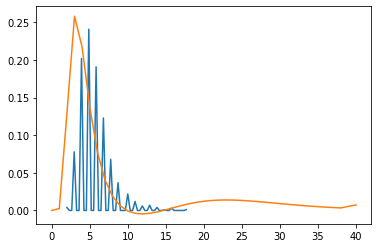

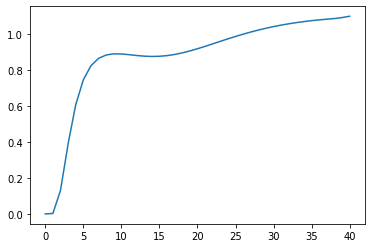

In [227]:
q = np.zeros((k,))
extras = np.zeros((k,))
# basura = np.zeros((k,))
acumulada = np.zeros((k,))

for i in range(k):
    aux = 0
    for j in range(i):
#         print(i,j)
        aux += theta[i, j] * q[j]

    extras[i] = aux
#     if A[i] - aux < 0:
#         q[i] = 0
#         q[i] = A[i] - aux
#         extras[i] = aux
#         basura[i] = A[i] - aux
#         pass
#     else:
    q[i] = A[i] - aux
    acumulada[i] += acumulada[i - 1] + q[i]

a = plt.hist(FPT, bins=50)
plt.show()
plt.plot(extras, label='extras')
plt.plot(A, label='A')
# plt.plot(basura, label='basura')
plt.legend()
plt.show()

b = a[0] / np.sum(a[0])
plt.plot(a[1][:-1], b)#, plt.show()
plt.plot(q)
plt.show()
plt.plot(acumulada)
plt.show()

Se debe calcular la probabilidad de forma analítica con lo que entregó el profe.

In [228]:
P_h = np.zeros((N - n,))
P_f = np.zeros((N - n,))
P = np.zeros((N - n + 1,))

P_h[0] = 1
P_f[0] = 0

for i in range(1,N - n):
    P_f[i] = norm.cdf((media[i] - u) / np.sqrt(varianza[i]))
    P_h[i] = (1 - P_f[i - 1]) * P_h[i - 1]
    P[i] = P_f[i] * P_h[i]
P[len(P) - 1] = 1 - np.sum(P[: len(P) - 1])

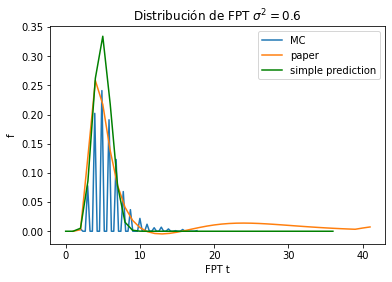

In [229]:
b = a[0] / np.max(a[0])
plt.plot(a[1][:-1], b / np.sum(b), label='MC')
plt.plot(np.array(range(len(q))) + 1, q, label='paper')
plt.xlabel('FPT t')
# plt.vlines(np.where(proceso >= u)[0][0] - n, 0, np.max(q), color='r', label='FPT proceso')
plt.plot(P, color='g', label='simple prediction')
plt.ylabel('f')
plt.title('Distribución de FPT $\sigma^2 =${}'.format(sigma))
plt.legend(loc='best')
plt.show()